In [1]:

from google.colab import drive
import pandas as pd
import numpy as np
import os

# --- CONFIGURATION ---
drive.mount('/content/drive')
MY_DRIVE_PATH = "/content/drive/MyDrive/MLProject"
DATA_FOLDER = os.path.join(MY_DRIVE_PATH, 'Data google sheet')
PROCESSED_CSV_FILE = os.path.join(DATA_FOLDER, 'One_Hot_Processed_Fruits_Data.csv')
SCALED_OUTPUT_FILE = os.path.join(DATA_FOLDER, 'All_Fruits_Scaled.csv')
OUTLIERS_OUTPUT_FILE = os.path.join(DATA_FOLDER, 'Outliers_Detected.csv')



Mounted at /content/drive


In [2]:
df = pd.read_csv(PROCESSED_CSV_FILE, sep=';', decimal='.')


In [ ]:
def scale_entire_dataset(input_path, output_path):
    # Load Data
    df = pd.read_csv(input_path, sep=';', decimal='.')
    cols_to_drop = ['Image_path', 'Text', 'Label']
    existing_drops = [c for c in cols_to_drop if c in df.columns]

    if existing_drops:
        df.drop(columns=existing_drops, inplace=True)

    #  scale
    continuous_cols = ["Weight", "Price"]
    image_cols = [col for col in df.columns if "img_" in col]
    text_cols = [col for col in df.columns if "text_" in col]

    columns_to_normalize = continuous_cols + image_cols + text_cols

    #Apply Z-Score Normalization
    epsilon = 1e-8

    for column in columns_to_normalize:
        mean = df[column].mean()
        std = df[column].std()
        df[column] = (df[column] - mean) / (std + epsilon)

    df.to_csv(output_path, index=False, sep=';', encoding='utf-8-sig')
    print(f"Full scaled dataset saved to: {output_path}")



In [ ]:
scale_entire_dataset(PROCESSED_CSV_FILE, SCALED_OUTPUT_FILE)

Full scaled dataset saved to: /content/drive/MyDrive/MLProject/Data google sheet/All_Fruits_Scaled.csv


In [3]:
def cosine_similarity(A, B):
    # Numerator
    dot_product = np.dot(A, B.T)

    #Denominator
    norm_A = np.linalg.norm(A, axis=1, keepdims=True) # Shape (N, 1)
    norm_B = np.linalg.norm(B, axis=1, keepdims=True) # Shape (M, 1)
    denominator = np.dot(norm_A, norm_B.T) + 1e-9

    return dot_product / denominator

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:

def analyze_similarity(file_path,original_path):
    df = pd.read_csv(file_path, sep=';', decimal='.')

    df_orig = pd.read_csv(original_path, sep=';')

    image_paths = df_orig["Image_path"].values

    target_col = 'Fruit'
    feature_cols = [c for c in df.columns if c != target_col]

    X = df[feature_cols].values
    y = df[target_col].values

    # Calculate Class Centroids
    classes = np.unique(y)
    centroids = {}

    print("\nCalculating Centroids")
    for cls in classes:
        # Get all samples for this class
        class_samples = X[y == cls]
        # Mean vector
        centroid = np.mean(class_samples, axis=0)
        centroids[cls] = centroid

    print("\nInter-Class Similarity Matrix")
    centroid_vectors = np.array([centroids[c] for c in classes])

    inter_sim_matrix = cosine_similarity(centroid_vectors, centroid_vectors)

    # Create DataFrame
    df_inter = pd.DataFrame(inter_sim_matrix, index=classes, columns=classes)
    print(df_inter)

    # Plot Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_inter, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt=".2f")
    plt.title("Inter-Class Similarity (Custom Cosine)")
    plt.show()

    #INTRA-CLASS SIMILARITY & OUTLIERS
    print("\nIntra-Class Similarity & Outlier Detection")

    outlier_count = 0
    results = []
    all_outliers = []

    for cls in classes:
        indices = np.where(y == cls)[0]
        class_samples = X[indices]
        centroid = centroids[cls].reshape(1, -1)

        sims = cosine_similarity(class_samples, centroid).flatten()

        # Stats
        avg_sim = np.mean(sims)
        std_sim = np.std(sims)

        # Outlier Threshold: Mean - 2 * StdDev
        threshold = avg_sim - (2 * std_sim)

        # indices[i] gives the original dataframe index
        local_outlier_indices = np.where(sims < threshold)[0]
        global_outlier_indices = indices[local_outlier_indices]
        for i, global_idx in enumerate(global_outlier_indices):
            similarity_score = sims[local_outlier_indices[i]]
            path = image_paths[global_idx]

            all_outliers.append({
                'Fruit_Class': cls,
                'Similarity_Score': similarity_score,
                'Class_Mean_Sim': avg_sim,
                'Threshold': threshold,
                'Image_Path': path
            })
        print(f"Class: {cls.ljust(10)} | Avg Sim: {avg_sim:.4f} | Std Dev: {std_sim:.4f} | Outliers: {len(local_outlier_indices)}")


    if all_outliers:
        df_outliers = pd.DataFrame(all_outliers)
        df_outliers = df_outliers.sort_values(by='Similarity_Score')
        df_outliers.to_csv(OUTLIERS_OUTPUT_FILE, index=False, sep=';', encoding='utf-8-sig')
        print(f"\nSaved detailed outlier list to: {OUTLIERS_OUTPUT_FILE}")




Calculating Centroids

Inter-Class Similarity Matrix
              apple    banana    orange  tangerine    tomato
apple      1.000000 -0.120769 -0.360835  -0.340711 -0.019058
banana    -0.120769  1.000000 -0.383458  -0.437557 -0.033707
orange    -0.360835 -0.383458  1.000000   0.522579 -0.473387
tangerine -0.340711 -0.437557  0.522579   1.000000 -0.439641
tomato    -0.019058 -0.033707 -0.473387  -0.439641  1.000000


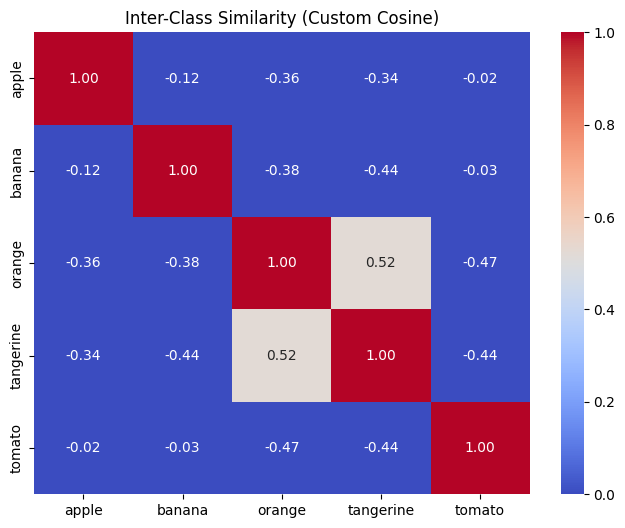


Intra-Class Similarity & Outlier Detection
Class: apple      | Avg Sim: 0.2154 | Std Dev: 0.0990 | Outliers: 3
Class: banana     | Avg Sim: 0.2488 | Std Dev: 0.1089 | Outliers: 20
Class: orange     | Avg Sim: 0.2414 | Std Dev: 0.1367 | Outliers: 1
Class: tangerine  | Avg Sim: 0.2276 | Std Dev: 0.0820 | Outliers: 9
Class: tomato     | Avg Sim: 0.2513 | Std Dev: 0.0759 | Outliers: 32

Saved detailed outlier list to: /content/drive/MyDrive/MLProject/Data google sheet/Outliers_Detected.csv


In [6]:
analyze_similarity(SCALED_OUTPUT_FILE,PROCESSED_CSV_FILE)

In [9]:

def run_analysis_for_modality(X, y, classes, modality_name):
    # Runs the full similarity analysis for a specific subset of features.
    centroids = {}
    for cls in classes:
        class_samples = X[y == cls]
        centroid = np.mean(class_samples, axis=0)
        centroids[cls] = centroid

    # INTER-CLASS SIMILARITY
    print(f"\n--- {modality_name}: Inter-Class Similarity ---")
    centroid_vectors = np.array([centroids[c] for c in classes])
    inter_sim_matrix = cosine_similarity(centroid_vectors, centroid_vectors)

    df_inter = pd.DataFrame(inter_sim_matrix, index=classes, columns=classes)
    print(df_inter)

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_inter, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt=".2f")
    plt.title(f"Inter-Class Similarity ({modality_name})")
    plt.show()

    #INTRA-CLASS SIMILARITY & OUTLIERS
    print(f"\n--- {modality_name}: Intra-Class & Outliers ---")
    outlier_count = 0
    results = []

    for cls in classes:
        indices = np.where(y == cls)[0]
        class_samples = X[indices]
        centroid = centroids[cls].reshape(1, -1)

        sims = cosine_similarity(class_samples, centroid).flatten()

        avg_sim = np.mean(sims)
        std_sim = np.std(sims)
        threshold = avg_sim - (2 * std_sim)

        outliers = indices[sims < threshold]
        num_outliers = len(outliers)
        outlier_count += num_outliers

        results.append({
            'Class': cls,
            'Avg Sim': avg_sim,
            'Outliers': num_outliers
        })

        print(f"Class: {cls.ljust(10)} | Avg Sim: {avg_sim:.4f} | Std Dev: {std_sim:.4f} | Outliers: {num_outliers}")

    print(f"\nTotal Outliers ({modality_name}): {outlier_count}")
    return pd.DataFrame(results)

def analyze_similarity_per_model(file_path):
    print(f"Loading scaled data from: {file_path}")
    df = pd.read_csv(file_path, sep=';')

    drop_keywords = ['image_path', 'text', 'label', 'resim']
    cols_to_drop = [c for c in df.columns if c.lower() in drop_keywords]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    # One-Hot Encode Categorical Strings
    string_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'Fruit' in string_cols:
        string_cols.remove('Fruit')

    if string_cols:
        print(f"One-Hot Encoding: {string_cols}")
        df = pd.get_dummies(df, columns=string_cols, prefix=string_cols)
        for col in df.columns:
            if df[col].dtype == 'bool':
                df[col] = df[col].astype(int)

    # Feature Groups
    target_col = 'Fruit'
    all_cols = [c for c in df.columns if c != target_col]

    # Image Features
    img_cols = [c for c in all_cols if 'img_' in c]

    #Text Features
    text_cols = [c for c in all_cols if 'text_' in c]

    #Categorical/Numerical
    cat_num_cols = [c for c in all_cols if c not in img_cols and c not in text_cols]

    y = df[target_col].values
    classes = np.unique(y)


    #Image
    if img_cols:
        X_img = df[img_cols].values
        run_analysis_for_modality(X_img, y, classes, "IMAGE FEATURES")

    #Text
    if text_cols:
        X_text = df[text_cols].values
        run_analysis_for_modality(X_text, y, classes, "TEXT FEATURES")

    #Categorical/Numerical
    if cat_num_cols:
        X_cat = df[cat_num_cols].values
        run_analysis_for_modality(X_cat, y, classes, "CATEGORICAL/NUMERICAL")



Loading scaled data from: /content/drive/MyDrive/MLProject/Data google sheet/All_Fruits_Scaled.csv

--- IMAGE FEATURES: Inter-Class Similarity ---
              apple    banana    orange  tangerine    tomato
apple      1.000000 -0.509667  0.157000  -0.415109 -0.353951
banana    -0.509667  1.000000 -0.529100   0.034645 -0.074317
orange     0.157000 -0.529100  1.000000  -0.359816 -0.228186
tangerine -0.415109  0.034645 -0.359816   1.000000 -0.198947
tomato    -0.353951 -0.074317 -0.228186  -0.198947  1.000000


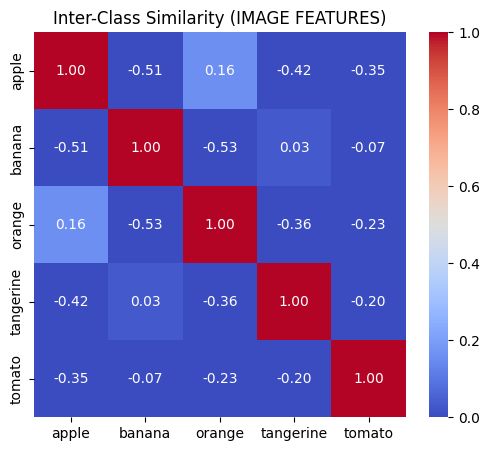


--- IMAGE FEATURES: Intra-Class & Outliers ---
Class: apple      | Avg Sim: -0.0758 | Std Dev: 0.2457 | Outliers: 0
Class: banana     | Avg Sim: 0.0940 | Std Dev: 0.2140 | Outliers: 0
Class: orange     | Avg Sim: 0.1319 | Std Dev: 0.1182 | Outliers: 2
Class: tangerine  | Avg Sim: 0.0596 | Std Dev: 0.1482 | Outliers: 0
Class: tomato     | Avg Sim: 0.3134 | Std Dev: 0.1614 | Outliers: 15

Total Outliers (IMAGE FEATURES): 17

--- TEXT FEATURES: Inter-Class Similarity ---
              apple    banana    orange  tangerine    tomato
apple      1.000000 -0.125438 -0.488146  -0.394025 -0.012426
banana    -0.125438  1.000000 -0.439726  -0.529724 -0.023468
orange    -0.488146 -0.439726  1.000000   0.642073 -0.559635
tangerine -0.394025 -0.529724  0.642073   1.000000 -0.550649
tomato    -0.012426 -0.023468 -0.559635  -0.550649  1.000000


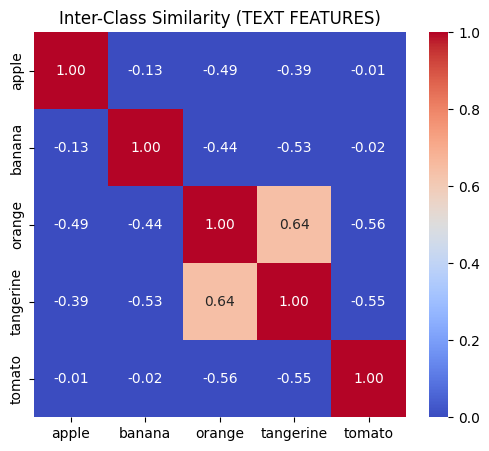


--- TEXT FEATURES: Intra-Class & Outliers ---
Class: apple      | Avg Sim: 0.2222 | Std Dev: 0.1100 | Outliers: 6
Class: banana     | Avg Sim: 0.2293 | Std Dev: 0.1284 | Outliers: 18
Class: orange     | Avg Sim: 0.2301 | Std Dev: 0.1586 | Outliers: 1
Class: tangerine  | Avg Sim: 0.2080 | Std Dev: 0.0978 | Outliers: 7
Class: tomato     | Avg Sim: 0.2458 | Std Dev: 0.0808 | Outliers: 33

Total Outliers (TEXT FEATURES): 65

--- CATEGORICAL/NUMERICAL: Inter-Class Similarity ---
              apple    banana    orange  tangerine    tomato
apple      1.000000  0.055690  0.509151  -0.038762  0.079606
banana     0.055690  1.000000 -0.094789  -0.183560 -0.104033
orange     0.509151 -0.094789  1.000000   0.208177  0.115707
tangerine -0.038762 -0.183560  0.208177   1.000000  0.123048
tomato     0.079606 -0.104033  0.115707   0.123048  1.000000


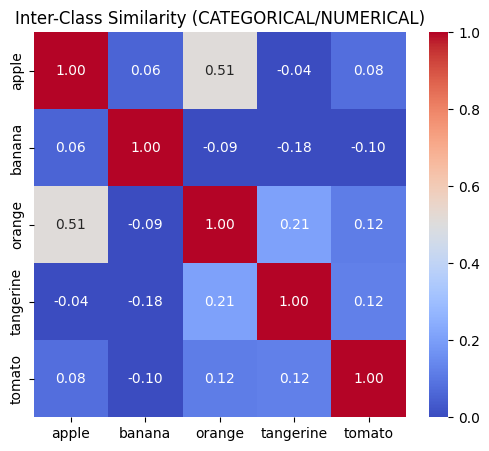


--- CATEGORICAL/NUMERICAL: Intra-Class & Outliers ---
Class: apple      | Avg Sim: 0.5867 | Std Dev: 0.0834 | Outliers: 28
Class: banana     | Avg Sim: 0.8720 | Std Dev: 0.0405 | Outliers: 34
Class: orange     | Avg Sim: 0.8594 | Std Dev: 0.1032 | Outliers: 39
Class: tangerine  | Avg Sim: 0.8984 | Std Dev: 0.0629 | Outliers: 34
Class: tomato     | Avg Sim: 0.7454 | Std Dev: 0.0442 | Outliers: 6

Total Outliers (CATEGORICAL/NUMERICAL): 141


In [10]:
analyze_similarity_per_model(SCALED_OUTPUT_FILE)